In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import sys
import itertools
import scipy.integrate

# Visualising the model

In [2]:
def build_states(threshold, system_capacity, parking_capacity):
    
    states_1 = [(0,v) for v in range(0, threshold)]
    states_2 = [(u,v) for v in range(threshold, system_capacity+1) for u in range(parking_capacity+1)]
    all_states = states_1 + states_2    
    
    return all_states

In [3]:
def visualise_ambulance_markov_chain(num_of_servers, threshold, parking_capacity, system_capacity):

    all_states = build_states(threshold, system_capacity, parking_capacity)
    G = nx.MultiDiGraph()
    for i, origin_state in enumerate(all_states):
        for j, destination_state in enumerate(all_states):
            column_adjacent = (destination_state[0] - origin_state[0] == 1 and destination_state[1] - origin_state[1] == 0)
            row_adjacent = (destination_state[1] - origin_state[1] == 1 and destination_state[0] - origin_state[0] == 0)
            if row_adjacent or column_adjacent:
                G.add_edge(origin_state, destination_state, color="blue")

    plt.figure(figsize=(1.5 * (parking_capacity+1), 1.5 * system_capacity))
    pos = {state:list(state) for state in all_states}
    nx.draw_networkx_nodes(G, pos, node_size=2000, nodelist=[state for state in all_states if state[1] < num_of_servers])
    nx.draw_networkx_nodes(G, pos, node_size=2000, nodelist=[state for state in all_states if state[1] >= num_of_servers], node_color='red')
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.axis('off');

# Getting individual entrys of the transition matrix (Symbolic/Exact)

In [4]:
def get_symbolic_transition_matrix_entry(origin, destination, threshold, lambda_a, lambda_o, Lambda, mu, num_of_servers):
    
    row_diff = origin[0] - destination[0]
    column_diff = origin[1] - destination[1]
    
    if row_diff == 0 and column_diff == -1:
        if origin[1] < threshold:
            return Lambda
        return lambda_o
    elif row_diff == -1 and column_diff == 0:
        return lambda_a
    elif row_diff == 0 and column_diff == 1:
        if origin[1] <= num_of_servers:
            return origin[1] * mu
        else:
            return num_of_servers * mu
    elif row_diff == 1 and column_diff == 0 and origin[1] == threshold:
        return threshold * mu
    else:
        return 0

In [5]:
def get_transition_matrix_entry(origin, destination, threshold, lambda_a, lambda_o, mu, num_of_servers):
    
    row_diff = origin[0] - destination[0]
    column_diff = origin[1] - destination[1]
    
    if row_diff == 0 and column_diff == -1:
        if origin[1] < threshold:
            return lambda_a + lambda_o
        return lambda_o
    elif row_diff == -1 and column_diff == 0:
        return lambda_a
    elif row_diff == 0 and column_diff == 1:
        if origin[1] <= num_of_servers:
            return origin[1] * mu
        else:
            return num_of_servers * mu
    elif row_diff == 1 and column_diff == 0 and origin[1] == threshold:
        return threshold * mu
    else:
        return 0

# Get the whole transition matrix (Symbolic/Exact)

In [6]:
def get_matrix(num_of_servers, threshold, system_capacity, parking_capacity): #TO BE DELETED
    
    Lambda = sym.symbols('Lambda')
    lambda_o = sym.symbols('lambda')**sym.symbols('o')
    lambda_a = sym.symbols('lambda')**sym.symbols('A')
    mu = sym.symbols('mu')
    
    all_states = build_states(threshold, system_capacity, parking_capacity)
    Q = sym.zeros(len(all_states))
    
    for i, origin_state in enumerate(all_states):
        for j, destination_state in enumerate(all_states):
            Q[i,j] = get_symbolic_transition_matrix_entry(origin=origin_state, destination=destination_state, threshold=threshold, lambda_a=lambda_a, lambda_o=lambda_o, Lambda=Lambda, mu=mu, num_of_servers=num_of_servers)
        Q[i, i] = - sum(Q[i,:])     # Clarify what the diagonal should be
    return Q

In [7]:
def get_symbolic_transition_matrix(num_of_servers, threshold, system_capacity, parking_capacity):

    Lambda = sym.symbols('Lambda')
    lambda_o = sym.symbols('lambda')**sym.symbols('o')
    lambda_a = sym.symbols('lambda')**sym.symbols('A')
    mu = sym.symbols('mu')

    all_states = build_states(threshold, system_capacity, parking_capacity)
    Q = sym.zeros(len(all_states))

    for (i, origin_state), (j, destination_state) in itertools.product(enumerate(all_states), repeat=2):
        Q[i, j] = get_symbolic_transition_matrix_entry(origin=origin_state, destination=destination_state, threshold=threshold, lambda_a=lambda_a, lambda_o=lambda_o, Lambda=Lambda, mu=mu, num_of_servers=num_of_servers)

    sum_of_rates = - np.sum(Q, axis=1)
    Q = Q + sym.Matrix(np.diag(sum_of_rates))

    return Q

In [8]:
def get_transition_matrix(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):

    all_states = build_states(threshold, system_capacity, parking_capacity)
    size = len(all_states)
    Q = np.zeros((size, size))

    for (i, origin_state), (j, destination_state) in itertools.product(enumerate(all_states), repeat=2):
        Q[i, j] = get_transition_matrix_entry(origin=origin_state, destination=destination_state, threshold=threshold, lambda_a=lambda_a, lambda_o=lambda_o, mu=mu, num_of_servers=num_of_servers)
    sum_of_rates = np.sum(Q, axis=1)
    np.fill_diagonal(Q, -sum_of_rates)    
    return Q

# Reviewing the model and transition matrix

In [9]:
lambda_a = 0.4
lambda_o = 0.3
mu = 0.4

num_of_servers = 2
threshold = 1
system_capacity = 4
parking_capacity = 1

In [10]:
Q_sym = get_symbolic_transition_matrix(num_of_servers, threshold, system_capacity, parking_capacity)
all_states = build_states(threshold, system_capacity, parking_capacity)

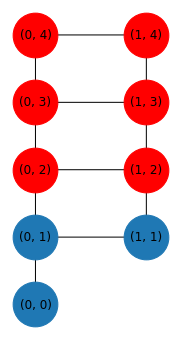

In [11]:
visualise_ambulance_markov_chain(num_of_servers, threshold, parking_capacity, system_capacity)

In [12]:
all_states

[(0, 0), (0, 1), (1, 1), (0, 2), (1, 2), (0, 3), (1, 3), (0, 4), (1, 4)]

In [13]:
Q_sym

Matrix([
[-Lambda,                      Lambda,               0,                             0,                 0,                             0,                 0,                 0,         0],
[     mu, -lambda**A - lambda**o - mu,       lambda**A,                     lambda**o,                 0,                             0,                 0,                 0,         0],
[      0,                          mu, -lambda**o - mu,                             0,         lambda**o,                             0,                 0,                 0,         0],
[      0,                        2*mu,               0, -lambda**A - lambda**o - 2*mu,         lambda**A,                     lambda**o,                 0,                 0,         0],
[      0,                           0,            2*mu,                             0, -lambda**o - 2*mu,                             0,         lambda**o,                 0,         0],
[      0,                           0,               0, 

# Building the transition matrix

In [14]:
lambda_a = 0.4
lambda_o = 0.3
mu = 0.05

num_of_servers = 8
threshold = 6
system_capacity = 14
parking_capacity = 15

In [15]:
Q = get_transition_matrix(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

In [16]:
all_states = build_states(threshold, system_capacity, parking_capacity)
all_states

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (1, 6),
 (2, 6),
 (3, 6),
 (4, 6),
 (5, 6),
 (6, 6),
 (7, 6),
 (8, 6),
 (9, 6),
 (10, 6),
 (11, 6),
 (12, 6),
 (13, 6),
 (14, 6),
 (15, 6),
 (0, 7),
 (1, 7),
 (2, 7),
 (3, 7),
 (4, 7),
 (5, 7),
 (6, 7),
 (7, 7),
 (8, 7),
 (9, 7),
 (10, 7),
 (11, 7),
 (12, 7),
 (13, 7),
 (14, 7),
 (15, 7),
 (0, 8),
 (1, 8),
 (2, 8),
 (3, 8),
 (4, 8),
 (5, 8),
 (6, 8),
 (7, 8),
 (8, 8),
 (9, 8),
 (10, 8),
 (11, 8),
 (12, 8),
 (13, 8),
 (14, 8),
 (15, 8),
 (0, 9),
 (1, 9),
 (2, 9),
 (3, 9),
 (4, 9),
 (5, 9),
 (6, 9),
 (7, 9),
 (8, 9),
 (9, 9),
 (10, 9),
 (11, 9),
 (12, 9),
 (13, 9),
 (14, 9),
 (15, 9),
 (0, 10),
 (1, 10),
 (2, 10),
 (3, 10),
 (4, 10),
 (5, 10),
 (6, 10),
 (7, 10),
 (8, 10),
 (9, 10),
 (10, 10),
 (11, 10),
 (12, 10),
 (13, 10),
 (14, 10),
 (15, 10),
 (0, 11),
 (1, 11),
 (2, 11),
 (3, 11),
 (4, 11),
 (5, 11),
 (6, 11),
 (7, 11),
 (8, 11),
 (9, 11),
 (10, 11),
 (11, 11),
 (12, 11),
 (13, 11),
 (14, 11),
 (15, 11),
 (0, 12),
 (1,

In [17]:
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=0)
Q

array([[-0.7 ,  0.7 ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.05, -0.75,  0.7 , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.1 , -0.8 , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ..., -0.8 ,  0.4 ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  , -0.8 ,  0.4 ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  , -0.4 ]])

# Steady State

In [18]:
def is_steady_state(state, Q):
    return np.allclose(np.dot(state, Q), 0)

In [22]:
def get_steady_state(Q, max_t=100, number_of_timepoints=1000, method=0):
    
    if method == 1:
        def derivative(x, t):
            return np.dot(x, Q)

        dimension = Q.shape[0]
        state = np.ones(dimension) / dimension
        while not is_steady_state(state=state, Q=Q):
            t_span = np.linspace(0, max_t, number_of_timepoints)
            sol = scipy.integrate.odeint(func=derivative, y0=state, t=t_span)
            state = sol[-1]
        return state

    if method == 2:
        def derivative(t, x):
            return np.dot(x, Q)

        dimension = Q.shape[0]
        state = np.ones(dimension) / dimension
        while not is_steady_state(state=state, Q=Q):
            t_span = np.linspace(0, max_t, number_of_timepoints)
            sol = scipy.integrate.solve_ivp(fun=derivative, y0=state, t_span=t_span)
            state = sol.y[:,-1]
        return state

In [23]:
sol1 = get_steady_state(Q, method=1)
print(is_steady_state(sol1, Q))
print(np.sum(sol1))

True
1.0000000000000067


In [24]:
sol2 = get_steady_state(Q, method=2)
print(is_steady_state(sol2, Q))
print(np.sum(sol2))

True
1.0000000000000047


# Dummy Cells